# Redes Neuronales Convolucionales (CNN) para la clasificación de imágenes

In [403]:
import pandas as pd
import numpy as np

In [404]:
from tensorflow.keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

##  Visualización de los datos de las imágenes

In [405]:
import matplotlib.pyplot as plt
%matplotlib inline

In [406]:
X_train.shape

(60000, 28, 28)

In [407]:
una_imagen = X_train[0]

In [408]:
una_imagen

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [409]:
una_imagen.shape

(28, 28)

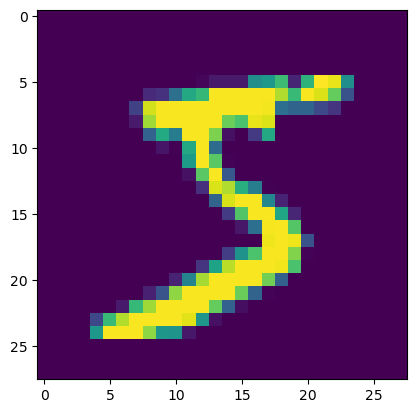

In [410]:
plt.imshow(una_imagen)

¿Qué está pasando acá?   ¿No se supone que es una imagen B-N?

Lo que pasa es que Matplotlib tiene una variedad de esquemas de colores "colormaps".  Si se desea, se puede cambiar el esquema para que se vea en B-N

# Pre-procesamiento de los datos

Es necesario asegurar que las etiquetas (metas) sean comprensibles por la CNN

## Etiquetas

In [411]:
y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [412]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

Parece que las etiquetas son literalmente categorías numéricas, pero están en formato numérico.  Será necesario convertirlas por el método de "one hot encoding" para que puedan ser usadas por la CNN, de lo contrario pensará que es algún tipo de problema de regresión sobre un eje contínuo.

Afortunadamente, Keras tiene una función fácil para hacer esta conversión:

In [413]:
from tensorflow.keras.utils import to_categorical

In [414]:
y_train.shape

(60000,)

In [415]:
ejemplo_y = to_categorical(y_train)

In [416]:
ejemplo_y

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [417]:
ejemplo_y.shape

(60000, 10)

In [418]:
ejemplo_y[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

el método to_categorical puede inferir, por default, el número de clases...y lo hace bastante bien.  Sin embargo, si se quiere estar seguro (podría ser que los datos no tuvieran uno de los valores posibles), o si fuera un caso más complicado, se puede especificar.  En este caso son 10

In [419]:
y_cat_test = to_categorical(y_test, 10)

In [420]:
y_cat_train = to_categorical(y_train, 10)

### Procesamiento de los datos X

Es mejor normalizar los datos de X

Normalmente se haría con el método MinMax() de sklearn, porque no se puede asumir que se sabe qué valores mínimo y máximo podrían venir en los datos futuros que quieran clasificar.  Sin embargo, como este ejercicio trata de imágenes, sí se conoce que todos los valores serán entre 0 y 255 por lo que se puede tomar una salida fácil.

In [421]:
una_imagen.max()

255

In [422]:
una_imagen.min()

0

In [423]:
X_train = X_train / 255
X_test = X_test / 255

In [424]:
una_normalizada = X_train[0]

In [425]:
una_normalizada.max()

1.0

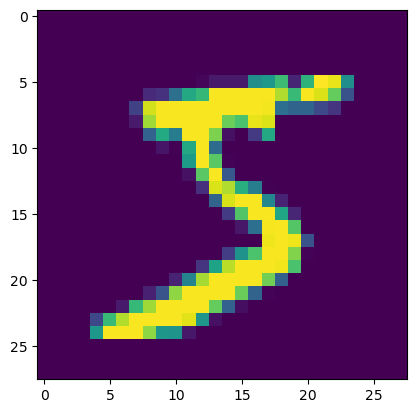

In [426]:
plt.imshow(una_normalizada)

Se puede ver que es exactamente igual!

## Cambiar el formato de los datos

Ahorita los datos son 60,000 imágenes almacenadas en un formato de 28 X 28 pixeles.

Esto es correcto para una CNN, pero es necesario agregar una dimensión más para mostrar que se está trabajando con un canal RGB (ya que, técnicamente, las imágenes están en B-N, y solo muestran valores entre 0-255 en un solo canal).  Una imagen a colores tendría 3 canales o dimensiones.

In [427]:
X_train.shape

(60000, 28, 28)

In [428]:
X_test.shape

(10000, 28, 28)

Modificar la forma para incluir la dimensión correspondiente al canal (en este caso es 1, cuando sea a colores es 3)

In [429]:
X_train = X_train.reshape(60000, 28, 28, 1)

In [430]:
X_train.shape

(60000, 28, 28, 1)

In [431]:
X_test = X_test.reshape(10000, 28, 28, 1)

In [432]:
X_test.shape

(10000, 28, 28, 1)

# Entrenamiento del modelo

Se hacen importaciones para poder crear capas normales, capas convolucionales, capas de pooling, y se necesita una capa para "aplanar" los datos (a una sola dimensión)

In [433]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [434]:
modelo = Sequential()

### Capa Convolucional

El número de filtros es configurable, generalmente se usa un múltiplo de 2.  El tamaño también es configurable, sin embargo es bueno ajustarlo al tamaño de la imágen.  Cómo el filtro se irá "corriendo", es bueno que el tamaño de la imagen sea un múltiplo del tamaño del filtro

In [435]:
modelo.add(Conv2D(filters = 32, kernel_size = (4, 4), input_shape = (28, 28, 1), activation = 'relu'))

### Capa de sub-muestreo (Pooling)

In [436]:
modelo.add(MaxPool2D(pool_size = (2, 2)))

### Capa parar aplanar 

Antes de llegar a la capa final es importante "aplanar" de 28 X 28 a 764 

In [437]:
modelo.add(Flatten())

### Capas escondidas

Serán de 128 "neuronas" o unidades (este valor es configurable)

In [438]:
modelo.add(Dense(200, activation = 'relu'))

### Agregando una segunda capa

In [439]:
modelo.add(Dense(200, activation = 'tanh'))

### Agregando más capas

In [440]:
# modelo.add(Dense(100, activation = 'relu'))
# modelo.add(Dense(75, activation = 'relu'))
# modelo.add(Dense(25, activation = 'relu'))

### La última capa es la clasificadora

Tenemos 10 posibles clases por lo que se usa la función de activación "softmax" que es para multi-clases

In [441]:
modelo.add(Dense(10, activation = 'softmax'))

### Se compila el modelo

Como una opción se pueden pedir una o más métricas, para ver cuáles hay, se puede consultar en:

https://keras.io/metrics/

In [442]:
modelo.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy'])

In [443]:
modelo.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 25, 25, 32)        544       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 flatten_12 (Flatten)        (None, 4608)              0         
                                                                 
 dense_38 (Dense)            (None, 200)               921800    
                                                                 
 dense_39 (Dense)            (None, 150)               30150     
                                                                 
 dense_40 (Dense)            (None, 10)                1510      
                                                     

### Uso de "callbacks"

Una forma de detener las épocas es usando el EarlyStopping.  Esto tiene un parámetro que se denomina "patience" que, como dice su nombre indica el grado de paciencia que debe tener una vez se detecta que el parámetro monitoreado empiece a desviarse de lo deseado.  La paciencia se mide en épocas, muchos usan 2 o 3 para dar chance a que el ultimo valor no haya sido alguna anomalidad, y darle otra oportunidad.

In [444]:
from tensorflow.keras.callbacks import EarlyStopping

In [445]:
detencion_temprana = EarlyStopping(monitor = 'val_loss', patience = 2)

## Entrenar el modelo

In [446]:
modelo.fit(X_train, y_cat_train, epochs = 10, validation_data = (X_test,y_cat_test),
           callbacks = [detencion_temprana])

Epoch 1/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.1216 - accuracy: 0.9629 - val_loss: 0.0558 - val_accuracy: 0.9808
Epoch 2/10
1875/1875 [==============================] - 18s 9ms/step - loss: 0.0418 - accuracy: 0.9873 - val_loss: 0.0514 - val_accuracy: 0.9824
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0261 - accuracy: 0.9919 - val_loss: 0.0412 - val_accuracy: 0.9866
Epoch 4/10
1875/1875 [==============================] - 18s 10ms/step - loss: 0.0169 - accuracy: 0.9945 - val_loss: 0.0454 - val_accuracy: 0.9861
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0500 - val_accuracy: 0.9869


## Evaluar el modelo

Para saber qué métricas hay disponibles:

In [447]:
modelo.metrics_names

['loss', 'accuracy']

In [448]:
metricas = pd.DataFrame(modelo.history.history)

In [449]:
metricas.head()

,loss,accuracy,val_loss,val_accuracy
0,0.121589,0.962867,0.055763,0.9808
1,0.041777,0.987333,0.051353,0.9824
2,0.026138,0.991883,0.041247,0.9866
3,0.016913,0.994533,0.045409,0.9861
4,0.013587,0.995567,0.049999,0.9869


<Axes: >

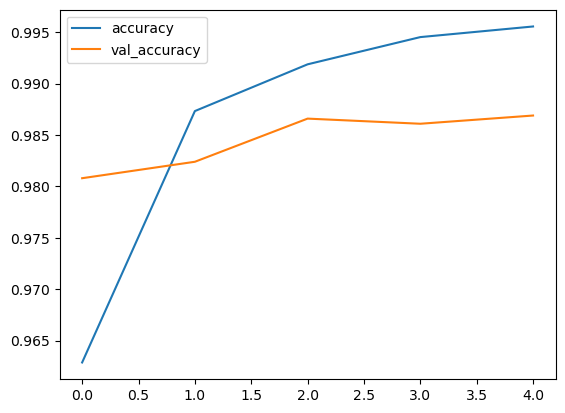

In [450]:
metricas[['accuracy', 'val_accuracy']].plot()

<Axes: >

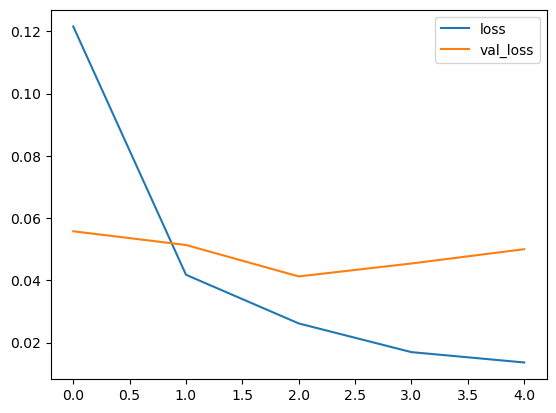

In [451]:
metricas[['loss', 'val_loss']].plot()

In [452]:
print(modelo.metrics_names)
print(modelo.evaluate(X_test, y_cat_test, verbose = 0))

['loss', 'accuracy']
[0.04999871551990509, 0.9868999719619751]


In [453]:
from sklearn.metrics import classification_report, confusion_matrix

Hasta hace poco, en Tensorflow se podía utilizar la instrucción:
    
    predicciones = modelo.predict_classes(X_test)
    
En las versiones más recientes de Tensorflow debe usarse:
    
Classification multiclase:
    
predicciones = np.argmax(modelo.predict(X_test), axis=-1)

Classification Binaria

predicciones = (modelo.predict(X_test) > 0.5).astype("int32")

In [454]:
#predicciones = modelo.predict_classes(X_test)
predicciones = np.argmax(modelo.predict(X_test), axis=-1)

313/313 [==============================] - 1s 4ms/step


In [455]:
y_cat_test.shape

(10000, 10)

In [456]:
y_cat_test[0]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.], dtype=float32)

In [457]:
predicciones[0]

7

In [458]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

In [459]:
print(classification_report(y_test, predicciones))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      1.00      0.99      1135
           2       0.98      1.00      0.99      1032
           3       0.98      1.00      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.98      0.99       958
           7       0.99      0.96      0.98      1028
           8       0.99      0.99      0.99       974
           9       0.97      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [460]:
confusion_matrix(y_test, predicciones)

array([[ 974,    0,    1,    1,    0,    0,    4,    0,    0,    0],
       [   0, 1131,    0,    2,    0,    0,    1,    0,    1,    0],
       [   1,    1, 1027,    1,    1,    0,    0,    1,    0,    0],
       [   0,    0,    1, 1007,    0,    1,    0,    0,    1,    0],
       [   0,    0,    0,    0,  968,    0,    1,    0,    0,   13],
       [   1,    0,    1,    4,    0,  884,    1,    0,    1,    0],
       [   6,    4,    1,    0,    1,    3,  942,    0,    1,    0],
       [   0,    6,   16,    9,    0,    0,    0,  984,    3,   10],
       [   1,    0,    2,    2,    0,    0,    0,    2,  961,    6],
       [   2,    0,    1,    4,    3,    4,    0,    2,    2,  991]],
      dtype=int64)

In [461]:
import seaborn as sns

<Axes: >

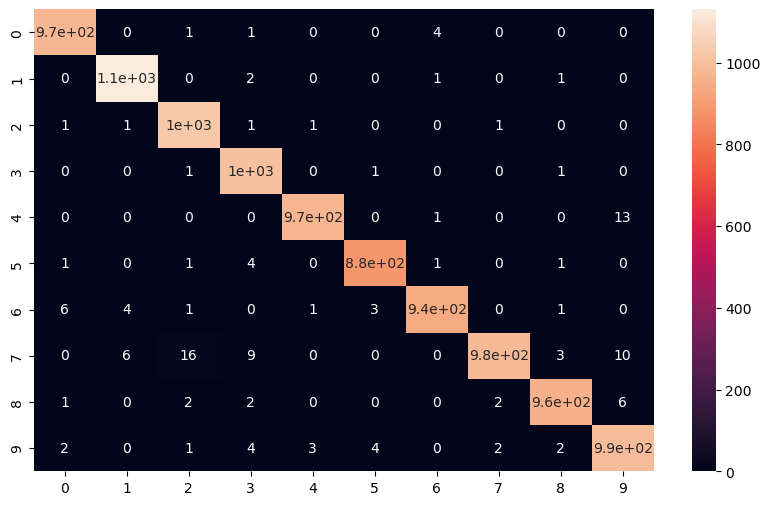

In [462]:
plt.figure(figsize = (10, 6))
sns.heatmap(confusion_matrix(y_test,predicciones),annot = True)

# Predecir una imagen dada

In [463]:
mi_numero = X_test[6]

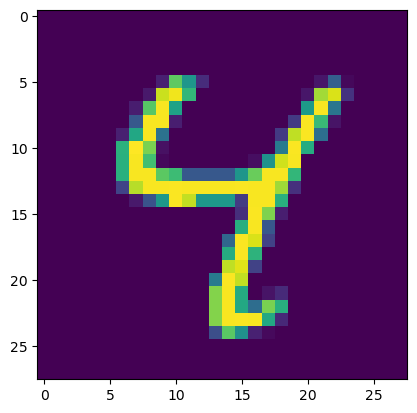

In [464]:
plt.imshow(mi_numero.reshape(28,28))

Recordar que la forma debe ser:  (num_imagenes, ancho, alto, num_canales_color)

In [465]:
np.argmax(modelo.predict(mi_numero.reshape(1,28,28,1)), axis=-1)
#modelo.predict_classes(mi_numero.reshape(1,28,28,1))

1/1 [==============================] - 0s 17ms/step


array([4], dtype=int64)

Parece que la CNN funciona bastante bien!

# Encontrando un mejor ancho para la red

In [466]:
# # Definir los tamaños de capa oculta a probar
# hidden_layer_sizes = [32, 64, 128, 256, 512]

# # Inicializar variables para almacenar el mejor modelo y su rendimiento
# best_val_accuracy = 0
# best_model = None

# # Realizar experimentos con diferentes tamaños de capas ocultas
# for size in hidden_layer_sizes:
#     model = Sequential()
#     model.add(Conv2D(filters=32, kernel_size=(4, 4), input_shape=(28, 28, 1), activation='relu'))
#     model.add(MaxPool2D(pool_size=(2, 2)))
#     model.add(Flatten())
#     model.add(Dense(size, activation='relu'))
#     model.add(Dense(10, activation='softmax'))
    
#     model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=2)
    
#     history = model.fit(X_train, y_cat_train, epochs=10, validation_data=(X_test, y_cat_test), callbacks=[early_stopping], verbose=0)
    
#     val_accuracy = max(history.history['val_accuracy'])
    
#     print(f"Hidden Layer Size: {size}, Validation Accuracy: {val_accuracy:.4f}")
    
#     if val_accuracy > best_val_accuracy:
#         best_val_accuracy = val_accuracy
#         best_model = model
#         best_history = history

# # Graficar el historial del mejor modelo
# plt.plot(best_history.history['accuracy'], label='accuracy')
# plt.plot(best_history.history['val_accuracy'], label='val_accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# plt.plot(best_history.history['loss'], label='loss')
# plt.plot(best_history.history['val_loss'], label='val_loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# print(f"Best Hidden Layer Size: {hidden_layer_sizes[best_history.history['val_accuracy'].index(best_val_accuracy)]}")